# Bigmart sales Prediction Project

## import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Load Dataset

In [2]:
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")


## EDA

In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


In [4]:
print(train.describe())

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


In [5]:
print(train.shape)

(8523, 12)


## visualizing the dataset

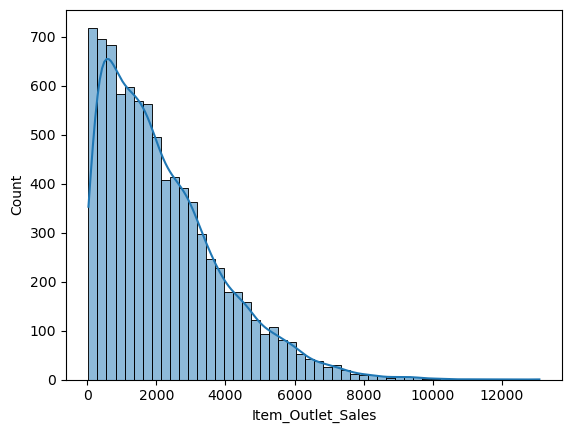

C:\Users\91983\AppData\Local\Temp\ipykernel_9784\1783762659.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap='coolwarm')


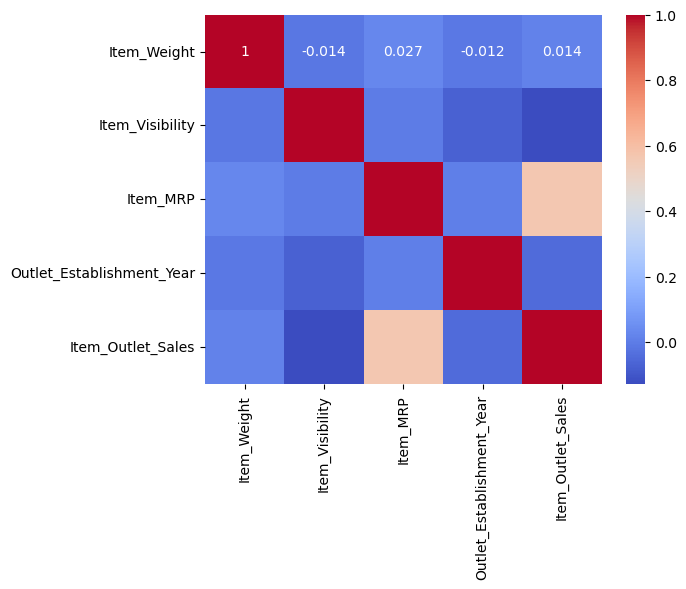

In [6]:
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True)
plt.show()
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()


## Data Cleaning and Preprocessing

In [7]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)


## Feature Engineering

In [8]:
from sklearn.preprocessing import LabelEncoder ,StandardScaler
le = LabelEncoder()
for column in ['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size', 'Item_Type']:
    train[column] = le.fit_transform(train[column])
    test[column] = le.transform(test[column])

train['Outlet_Age'] = 2025 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = train.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
X_test = test.drop(columns=['Item_Identifier', 'Outlet_Identifier'])
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

## Model Building

In [13]:
from sklearn.model_selection import train_test_split,cross_val_score
# Train-Test Split
y = train['Item_Outlet_Sales']
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Selection and Training

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [16]:
import numpy as np
# Cross-Validation
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE (Gradient Boosting): {rmse_cv.mean()} ± {rmse_cv.std()}')

Cross-Validation RMSE (Gradient Boosting): 1097.162063490886 ± 15.207964017456021


## Model Evaluation and Hyperparameter Tuning

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_gb = gb_model.predict(X_val)
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
print(f'Validation RMSE (Gradient Boosting): {rmse_gb}')

Validation RMSE (Gradient Boosting): 1034.1331695423362


In [18]:
import numpy as np
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

def tune_gradient_boosting(X_train, y_train, use_random_search=False):
    param_grid_gb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 1.0]
    }

    if use_random_search:
        search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42), 
                                    param_distributions=param_grid_gb, 
                                    n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
    else:
        search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), 
                              param_grid=param_grid_gb, 
                              cv=3, n_jobs=-1, verbose=2)

    start_time = time()
    search.fit(X_train, y_train)
    end_time = time()

    best_params_gb = search.best_params_
    best_model_gb = search.best_estimator_
    print(f'Best Parameters (Gradient Boosting): {best_params_gb}')
    print(f'Best Cross-Validation Score: {search.best_score_}')
    print(f'Time taken for search: {end_time - start_time:.2f} seconds')
    return best_model_gb

# Example usage
best_model_gb = tune_gradient_boosting(X_train, y_train, use_random_search=True)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters (Gradient Boosting): {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.05}
Best Cross-Validation Score: 0.5927550726133507
Time taken for search: 50.45 seconds


## Final Model Training and Prediction

In [19]:
# Final Model Training and Prediction using Gradient Boosting
best_model_gb.fit(X_scaled, y)
predictions = best_model_gb.predict(X_test_scaled)

# Ensure no negative values in predictions
predictions = np.maximum(predictions, 0)

test['Item_Outlet_Sales'] = predictions

## Prepare Submission File

In [20]:
# Save the predictions to a CSV file
GB = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
GB.to_csv('GradientBoosting.csv', index=False)
print("Predictions saved to GradientBoosting.csv")

Predictions saved to GradientBoosting.csv


successfully completed